# Example 5.2: CRR Model with uncertainty about $\kappa$

First, include the necessary functions.
The linear programming solver requires the gurobi package!

In [3]:
source(file="functions.r")

Warning message:
"package 'linprog' was built under R version 3.6.2"Loading required package: lpSolve
Warning message:
"package 'lpSolve' was built under R version 3.6.2"Warning message:
"package 'gurobi' was built under R version 3.6.2"Loading required package: slam
Warning message:
"package 'slam' was built under R version 3.6.2"

We first define the AR(1) Function to simulate the process

In [4]:
# Ar_1 Function for simulations
AR_1<-function(t=0.1,N=10000,mu=100,k=0.1,sigma=20,plot=T,plot_threshold=2*sigma,S_0=100){
  norm_rv<-rnorm(N,mean=0,sd=t*sigma)
  #  norm_rv<-rep(1,N)
  Y<-numeric(N)
  Y[1]<-S_0
  for(i in 2:N){
    Y[i]<-Y[i-1]+k*(mu-Y[i-1])*t+norm_rv[i]
  }
  # Y<-arima.sim(list( ar=(1-k*t),innov=(norm_rv+rep(k*mu*t,N))),n.start = 1,start.innov = mu,n=N)[1:N]
  if(plot){
    plot(1:N,Y,type='l',col="black",lwd=0.5,xlab="Time",ylab="Spread")
    abline(h=mu+plot_threshold,lty=2)
    abline(h=mu,lty=2)
    abline(h=mu-plot_threshold,lty=2)
  }
  return(Y)
  
}

Then we set the parameters (with uncertainty in the mean $\kappa \in [0.005,0.1]$, here modelled by the variable $kk$)

In [3]:
N<-5 # different Parameters
n<-100 # time steps 
n_discr<-50
time_diff<-1
kk<-seq(0.005,0.1,length=N)
# Setting Parameters
mu<-seq(0,0,length=N)
sigma<-seq(1,1,length=N)
S_0<-0
## Values
x<-matrix(0,N,n_discr)
y<-matrix(0,N,n_discr)
standard_dev<-0
for(j in 0:(n/2)){
  standard_dev<-standard_dev+((1-kk*time_diff)^j)*sigma*time_diff
}
standard_dev<-sqrt(standard_dev)
## randomize
kk<-sample(kk,N)
mu<-sample(mu,N)
sigma<-sample(sigma,N)

# probabilities
prob_set<-array(0,dim=c(N,n_discr,n_discr))
for(i in 1:N){
  # Assigning Values
  x[i,]<-seq(S_0-50,S_0+50,length=n_discr)
  y[i,]<-seq(S_0-50,S_0+50,length=n_discr)
  for(j in 1:n_discr){
    for(k in 1:n_discr){
      # Assigning Probabilities
      prob_set[i,j,k]<-dnorm(x[i,j],mean=mu[i]*(1-(1-kk[i]*time_diff)^(n/2))+((1-kk[i]*time_diff)^(n/2))*S_0,sd=standard_dev[i])*dnorm(y[i,k],mean=mu[i]*(1-(1-kk[i]*time_diff)^(n/2))+((1-kk[i]*time_diff)^(n/2))*x[i,j],sd=standard_dev[i])
    }
  }
  prob_set[i,,]<-prob_set[i,,]/sum(prob_set[i,,])
}

### Removing too low probabilities
epsilon<-0.0001
for(i in 1:N){
  for(j in 1:n_discr){
    for(k in 1:n_discr){
      if((prob_set[i,j,k])<epsilon){
        prob_set[i,j,k]<-0
      }
    }
  }
  prob_set[i,,]<-prob_set[i,,]/sum(prob_set[i,,])
}

We consider as "payoff function" $c(x,y) \equiv 0$ to compute statistical arbtirage strategies. The maximal investment amount is set to $K =10$

In [4]:
func1<-function(x,y){0}

# Computation of the Bounds
limit<-10

# Robust Bounds
check_statarb(x[1,],y[1,],prob_set[1,,],S_0)
lower_bound_nosa<-super_rep(x,y,prob_set,func=func1,stat_arb=F,lower=T,S_0,limit)
lower_bound<-super_rep_robust(x,y,prob_set,func=func1,stat_arb=T,lower=T,S_0,limit)
upper_bound<-super_rep_robust(x,y,prob_set,func=func1,stat_arb=T,lower=F,S_0,limit)
upper_bound_nosa<-super_rep(x,y,prob_set,func=func1,stat_arb=F,lower=F,S_0,limit)

[1] "There is Statistical Arbitrage"


We simulate the profit arising from the above computed statistical arbitrage strategy

In [5]:
# Simulations
## Statistical Arbitrage
Delta_0_upper<-upper_bound$Delta_0
kk<-sample(kk,N)
mu<-sample(mu,N)
sigma<-sample(sigma,N)
Delta_1_upper<-splinefun(upper_bound$x,upper_bound$Delta_1,method="natural")
#plot(upper_bound$x,Delta_1_upper(upper_bound$x),type="l")
nr_gains<-0
nr_losses<-0
d_upper<-upper_bound$d
gain<-0
Nr_sim<-1000000
best<-0
worst<-0
ff1<-numeric(Nr_sim)
for(i in 1:Nr_sim){
  ii<-sample(1:N,1) # choosing random parameter
  jj<-sample(1:N,1) 
  ll<-sample(1:N,1)
  S<-AR_1(t=time_diff,N=n+1,mu=mu[ii],k=kk[jj],sigma=sigma[ll],plot=F,plot_threshold=2*sigma,S_0=S_0)
  f<-(Delta_0_upper*(S[n/2]-S_0)+Delta_1_upper(S[n/2])*(S[n]-S[n/2]))
  ff1[i]<-f
  gain<-gain+f
  if(f<0){nr_losses<-nr_losses+1}
  if(f>0){nr_gains<-nr_gains+1}
  if(f>best){best<-f}
  if(f<worst){worst<-f}
}
print("Average Profit")
gain/Nr_sim
print("Best Gain")
best
print("Worst Loss")
worst
print("% Loss Scenarios")
nr_losses/Nr_sim
print("% Gain Scenarios")
nr_gains/Nr_sim

[1] "Average Profit"


[1] 2.980023e-05

[1] "Best Gain"


[1] 179.2946

[1] "Worst Loss"


[1] -206.5296

[1] "% Loss Scenarios"


[1] 0.499623

[1] "% Gain Scenarios"


[1] 0.500377

We define delta strategies for pairs trading

In [10]:
########## Delta Strategies ###############
################# PAIRS TRADING ###########
Delta_strat<-function(N,eps=20,delta=0.001,Y,mu=0,intermediate_NR=N-1){
  ## Define Trading Points
  trading_times<-round(seq(N/(intermediate_NR+1),N*intermediate_NR/(intermediate_NR+1),length=intermediate_NR)+1,0)
  Delta<-numeric(N)
  for(i in 2:N){
    if((Y[i]>=(mu+eps))*(Delta[i-1]==0)*(i %in% trading_times)){
      Delta[i]<-(Delta [i-1]-1)
    }
    else if((Y[i]>=(mu-delta))*(Delta[i-1]==1)*(i %in% trading_times)){
      Delta[i]<-(Delta [i-1]-1)
    }
    else if((Y[i]<=(mu-eps))*(Delta[i-1]==0)*(i %in% trading_times)){
      Delta[i]<-(Delta [i-1]+1)
    }
    else if((Y[i]<=(mu+delta))*(Delta[i-1]==(-1))*(i %in% trading_times)){
      Delta[i]<-(Delta [i-1]+1)
    }
    else{
      Delta[i]<-(Delta [i-1])
    }
  }
  return(Delta)
}
Gain<-function(Delta,N,S){
  G<-numeric(N)
  for(i in 2:N){
    G[i]<-Delta[i-1]*(S[i]-S[i-1])
  }
  G<-cumsum(G)
  # print(G[N])
  return(G)
}

and compute their profit in this scenario

In [7]:
#epsilon=2*sigma
nr_gains<-0
nr_losses<-0
gain<-0
Nr_sim<-1000000
best<-0
worst<-0
ff2<-numeric(Nr_sim)
for(sim in 1:Nr_sim){
  ii<-sample(1:N,1) # choosing random parameter
  jj<-sample(1:N,1) 
  ll<-sample(1:N,1)
  S<-AR_1(t=time_diff,N=n+1,mu=mu[ii],k=kk[jj],sigma=sigma[ll],plot=F,plot_threshold=2*sigma,S_0=S_0)
  D1<-Delta_strat(N=n+1,eps=2*sigma[ii],delta=0.001,S,mu[ii])
  f<-Gain(D1,(n+1),S)[n+1]
  ff2[sim]<-f
  gain<-gain+f
  if(f<0){nr_losses<-nr_losses+1}
  if(f>=0){nr_gains<-nr_gains+1}
  if(f>best){best<-f}
  if(f<worst){worst<-f}
}
print("Average Profit")
gain/Nr_sim
print("Best Gain")
best
print("Worst Loss")
worst
print("% Loss Scenarios")
nr_losses/Nr_sim
print("% Gain Scenarios")
nr_gains/Nr_sim

[1] "Average Profit"


[1] 9.759987

[1] "Best Gain"


[1] 41.55156

[1] "Worst Loss"


[1] -35.27108

[1] "% Loss Scenarios"


[1] 0.098863

[1] "% Gain Scenarios"


[1] 0.901137

We plot the corresponding histograms

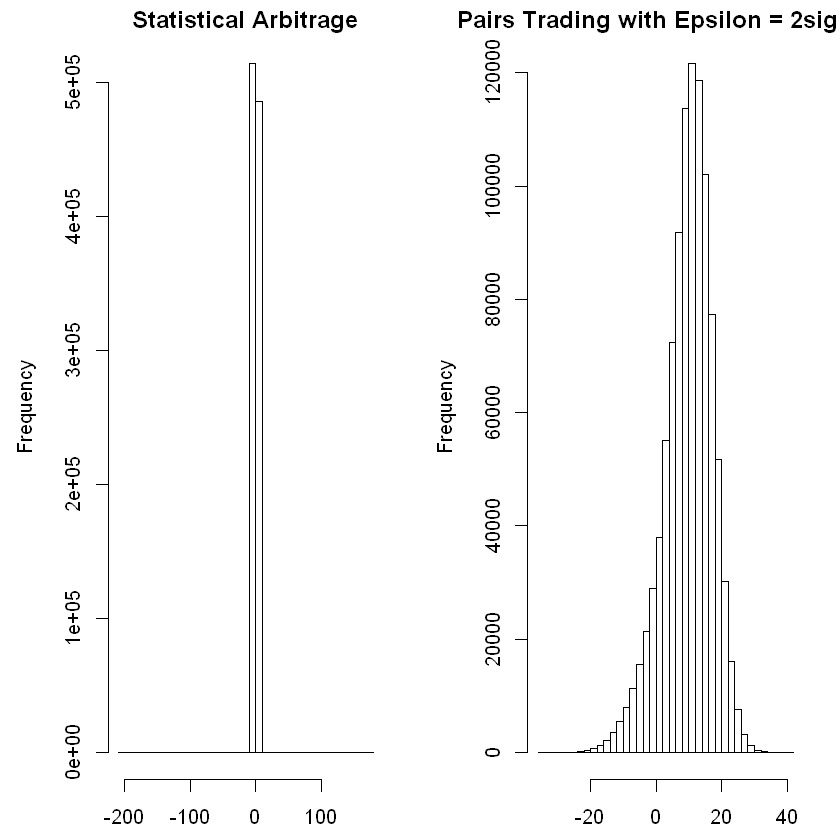

In [8]:
par(mfrow=c(1,2))
par(mar=c(2.5, 4.5,1.5, 1.5))
hist(ff1,xlab="Average Gain",main="Statistical Arbitrage",breaks=50)
hist(ff2,xlab="Average Gain",main="Pairs Trading with Epsilon = 2sigma",breaks=50)

We define a function for the consideration of more trading points

In [2]:
################ More trading points #########################
more_trading<-function(Nr_sim=1000,nr_trading_points=1,bad_scenarios=F){

f<-0
nr_gains<-0
nr_losses<-0
gain<-0
best<-0
worst<-0
standard_dev<-0
for(j in 0:(n/(nr_trading_points+1))){
  standard_dev<-standard_dev+((1-kk*time_diff)^j)*sigma*time_diff
}
standard_dev<-sqrt(standard_dev)

if(bad_scenarios){
  ff<-NULL
  for(s in bad_seeds){
    set.seed(s)
    S<-AR_1(time_diff,N=n+1,mu[1],k=kk[1],sigma[1],plot=F,plot_threshold = 2*sigma,S_0=S_0)
  for(h in 1:nr_trading_points){
    ## Values
    x<-matrix(0,N,n_discr)
    y<-matrix(0,N,n_discr)
    
    # probabilities
    prob_set<-array(0,dim=c(N,n_discr,n_discr))
    for(i in 1:N){
      # Assigning Values
      x[i,]<-seq(S_0-50/nr_trading_points,S_0+50/nr_trading_points,length=n_discr)
      y[i,]<-seq(S_0-50/nr_trading_points,S_0+50/nr_trading_points,length=n_discr)
      for(j in 1:n_discr){
        for(k in 1:n_discr){
          # Assigning Probabilities
          prob_set[i,j,k]<-dnorm(x[i,j],mean=mu[i]*(1-(1-kk[i]*time_diff)^((n/(nr_trading_points+1))))+((1-kk[i]*time_diff)^((n/(nr_trading_points+1))))*S_0,sd=standard_dev[i])*dnorm(y[i,k],mean=mu[i]*(1-(1-kk[i]*time_diff)^(n/(nr_trading_points+1)))+((1-kk[i]*time_diff)^(n/(nr_trading_points+1)))*x[i,j],sd=standard_dev[i])
        }
      }
      prob_set[i,,]<-prob_set[i,,]/sum(prob_set[i,,])
    }
    
    
    
    # Robust Bounds
    upper_bound<-super_rep_robust(x,y,prob_set,func=function(x,y){0},stat_arb=T,lower=F,S_0,limit=10)
    Delta_0_upper<-upper_bound$Delta_0
    Delta_1_upper<-splinefun(upper_bound$x,upper_bound$Delta_1,method="natural")
    
    
    
    f<-f+(Delta_0_upper*(S[(h*n)/(nr_trading_points+1)]-S_0)+Delta_1_upper(S[((h)*n)/(nr_trading_points+1)])*(S[((h+1)*n)/(nr_trading_points+1)]-S[(h*n)/(nr_trading_points+1)]))
    S_0<-S[(h*n)/(nr_trading_points+1)]

  }
  ff<-c(ff,f)
  gain<-gain+f
  if(f<0){nr_losses<-nr_losses+1}
  if(f>0){nr_gains<-nr_gains+1}
  if(f>best){best<-f}
  if(f<worst){worst<-f}
  f<-0
  S_0<-0
  
  }
  hist(ff,xlab="Average Gain",main=paste("Stat. Arb with ",  nr_trading_points, " Trades", sep=" "),breaks=50)
  return(list(
    AVERAGE_GAIN=round(gain/length(bad_seeds),2),
    BEST=round(best,2),
    WORST=round(worst,2),
    LOSSES=round(100*nr_losses/length(bad_seeds),2),
    GAINS=round(100*nr_gains/length(bad_seeds),2)
  )
  )
}
else{
  ff<-numeric(Nr_sim)

for(sim in 1:Nr_sim){
  ii<-sample(1:N,1) # choosing random parameter
  S<-AR_1(t=time_diff,N=n,mu=mu[ii],k=kk[ii],sigma=sigma[ii],plot=F,plot_threshold=2*sigma,S_0=S_0)
  for(h in 1:nr_trading_points){
    ## Values
    x<-matrix(0,N,n_discr)
    y<-matrix(0,N,n_discr)
    
    # probabilities
    prob_set<-array(0,dim=c(N,n_discr,n_discr))
    for(i in 1:N){
      # Assigning Values
      x[i,]<-seq(S_0-50/nr_trading_points,S_0+50/nr_trading_points,length=n_discr)
      y[i,]<-seq(S_0-50/nr_trading_points,S_0+50/nr_trading_points,length=n_discr)
      for(j in 1:n_discr){
        for(k in 1:n_discr){
          # Assigning Probabilities
          prob_set[i,j,k]<-dnorm(x[i,j],mean=mu[i]*(1-(1-kk[i]*time_diff)^((n/(nr_trading_points+1))))+((1-kk[i]*time_diff)^((n/(nr_trading_points+1))))*S_0,sd=standard_dev[i])*dnorm(y[i,k],mean=mu[i]*(1-(1-kk[i]*time_diff)^(n/(nr_trading_points+1)))+((1-kk[i]*time_diff)^(n/(nr_trading_points+1)))*x[i,j],sd=standard_dev[i])
        }
      }
      prob_set[i,,]<-prob_set[i,,]/sum(prob_set[i,,])
    } 
    
    
    # Robust Bounds
    upper_bound<-super_rep_robust(x,y,prob_set,func=function(x,y){0},stat_arb=T,lower=F,S_0,limit=10)
    Delta_0_upper<-upper_bound$Delta_0
    Delta_1_upper<-splinefun(upper_bound$x,upper_bound$Delta_1,method="natural")
    
    
    
    f<-f+(Delta_0_upper*(S[(h*n)/(nr_trading_points+1)]-S_0)+Delta_1_upper(S[((h)*n)/(nr_trading_points+1)])*(S[((h+1)*n)/(nr_trading_points+1)]-S[(h*n)/(nr_trading_points+1)]))
    S_0<-S[(h*n)/(nr_trading_points+1)]
    ff[sim]<-f
  }
  gain<-gain+f
  if(f<0){nr_losses<-nr_losses+1}
  if(f>0){nr_gains<-nr_gains+1}
  if(f>best){best<-f}
  if(f<worst){worst<-f}
  f<-0
  S_0<-0
}
}
    hist(ff,xlab="Average Gain",main=paste("Stat. Arb with ",  nr_trading_points, " Trades", sep=" "),breaks=50)
return(list(
AVERAGE_GAIN=round(gain/Nr_sim,2),
BEST=round(best,2),
WORST=round(worst,2),
LOSSES=round(100*nr_losses/Nr_sim,2),
GAINS=round(100*nr_gains/Nr_sim,2)
)
)

}

We show in a histogram the associated average gain

We compare the profits from more than 1 trading point (Takes some time when increasing the number of scenarios)

[1] "1 Trade"


$AVERAGE_GAIN
[1] -1.07

$BEST
[1] 69.78

$WORST
[1] -113.54

$LOSSES
[1] 51.3

$GAINS
[1] 48.7

[1] "4 Trades"


$AVERAGE_GAIN
[1] 2.95

$BEST
[1] 333.98

$WORST
[1] -232.64

$LOSSES
[1] 49.8

$GAINS
[1] 50.2

[1] "9 Trades"


$AVERAGE_GAIN
[1] 18.86

$BEST
[1] 307.51

$WORST
[1] -283.89

$LOSSES
[1] 43.7

$GAINS
[1] 56.3

[1] "19 Trades"


$AVERAGE_GAIN
[1] 23.58

$BEST
[1] 315.97

$WORST
[1] -294.96

$LOSSES
[1] 40.2

$GAINS
[1] 59.8

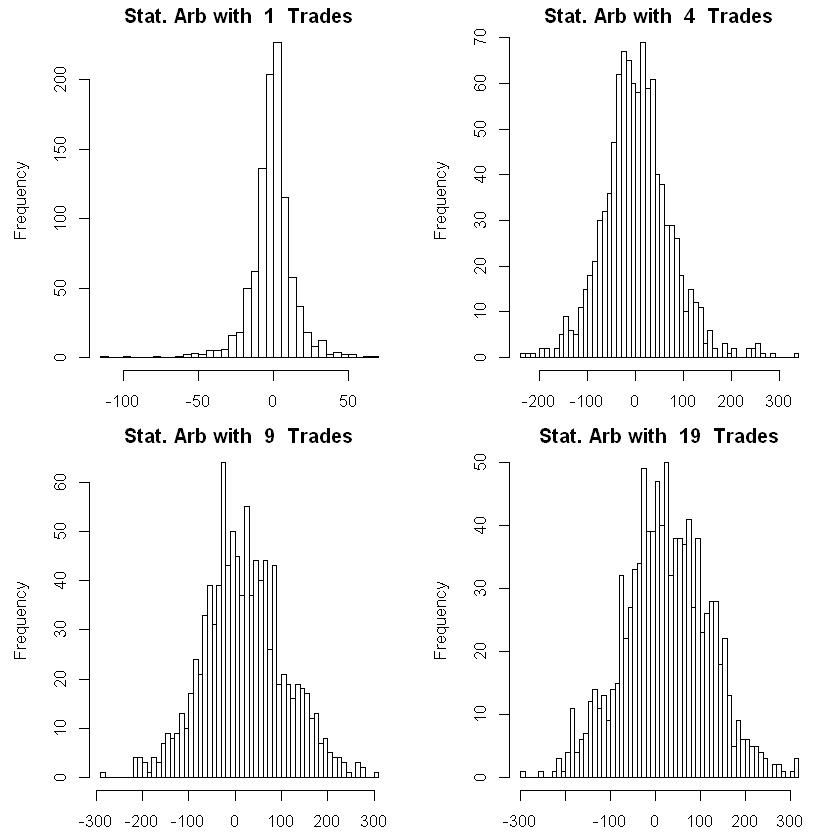

In [10]:
par(mfrow=c(2,2))
par(mar=c(2.5, 4.5,1.5, 1.5))

nr_scenarios = 1000 #(In Paper: 10000)
print("1 Trade")
more_trading(nr_scenarios,1,bad_scenarios = F)
print("4 Trades")
more_trading(nr_scenarios,4)
print("9 Trades")
more_trading(nr_scenarios,9)
print("19 Trades")
more_trading(nr_scenarios,19)

Eventually we investigate bad_scenarios. We first consider pairs trading in these scenarios

In [14]:
########################################################
########### Investigating Bad Scenarios ################
########################################################
N<-5 # different Parameters
n<-100 # time steps 
n_discr<-50
time_diff<-1
kk<-seq(0.005,0.1,length=N)
mu<-seq(0,0,length=N)
sigma<-seq(1,1,length=N)
S_0<-0


########## Picking the worst Scenarios
#Nr of bad scenarios
bad_seeds<-NULL
nr_possible_scenarios <-10000 
for(s in 1:nr_possible_scenarios){
set.seed(s)
Y<-AR_1(time_diff,N=n+1,mu[1],k=kk[1],sigma[1],plot=F,plot_threshold = 2*sigma,S_0=S_0)
if(abs(Y[n+1])>12){bad_seeds<-c(bad_seeds,s)}
}

bad_seeds_copy<-bad_seeds
bad_seeds<-bad_seeds_copy[1:1000]
### Investigating Success on these scenarios

### Pairs Trading ####
nr_gains<-0
nr_losses<-0
gain<-0
best<-0
worst<-0
ff<-numeric(length(bad_seeds))
for(s in bad_seeds){
  set.seed(s)
  S<-AR_1(time_diff,N=n+1,mu[1],k=kk[1],sigma[1],plot=F,plot_threshold = 2*sigma,S_0=S_0)
  D1<-Delta_strat(N=n+1,eps=2*sigma[1],delta=0.001,S,mu[1],intermediate_NR=3)
  f<-Gain(D1,(n+1),S)[n+1]
  ff[s]<-f
  gain<-gain+f
  if(f<0){nr_losses<-nr_losses+1}
  if(f>=0){nr_gains<-nr_gains+1}
  if(f>best){best<-f}
  if(f<worst){worst<-f}
}
print("Average Profit")
round(gain/length(bad_seeds),2)
print("Best Gain")
round(best,2)
print("Worst Loss")
round(worst,2)
print("% Loss Scenarios")
round(100*nr_losses/length(bad_seeds),2)
print("% Gain Scenarios")
round(100*nr_gains/length(bad_seeds),2)

[1] "Average Profit"


[1] -7.85

[1] "Best Gain"


[1] 21.19

[1] "Worst Loss"


[1] -22.72

[1] "% Loss Scenarios"


[1] 91.4

[1] "% Gain Scenarios"


[1] 8.6

Then, we compute the corresponding profit for statistical arbitrage and plot the histograms

$AVERAGE_GAIN
[1] 1.26

$BEST
[1] 294.33

$WORST
[1] -413.55

$LOSSES
[1] 46.7

$GAINS
[1] 53.3

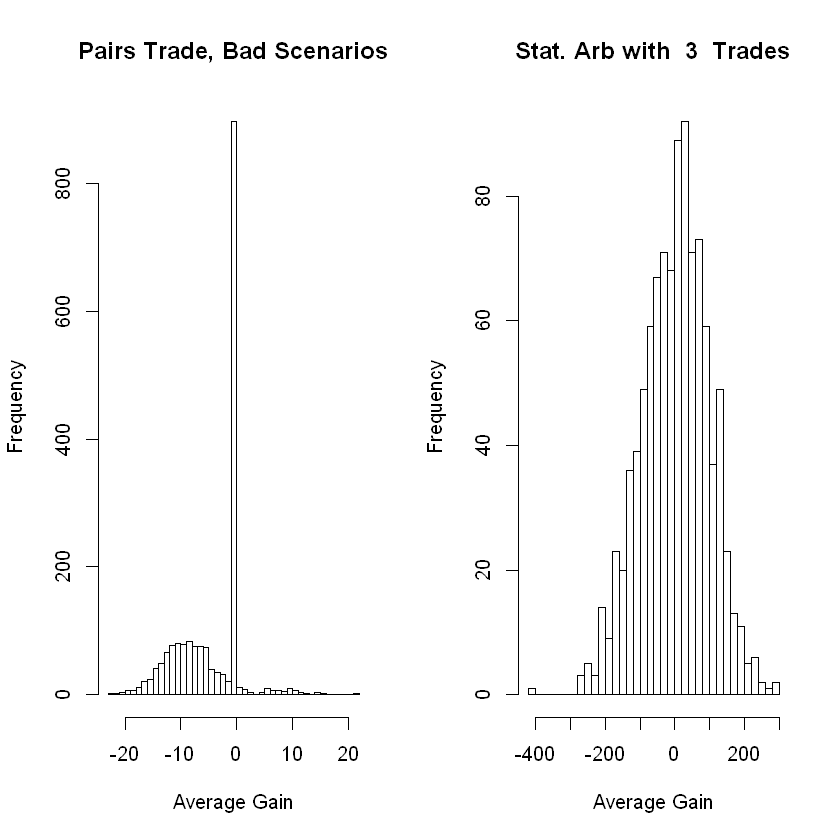

In [15]:
par(mfrow=c(1,2))
hist(ff,xlab="Average Gain",main=paste("Pairs Trade, Bad Scenarios"),breaks=50)
more_trading(1000,3,bad_scenarios=T)